In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta
import math
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional
from keras.layers import Dense
from sklearn.model_selection import train_test_split
import time
import os

### Files

In [4]:
data=pd.read_csv('Data/2020.csv',low_memory=False)
data.head(3)

,Branch,City,Service Desk,Service,Generalized Service PB,Ticket Number,Creation Time,Creation time year,Month,Creation time month nr,...,Creation time week nr,Weekday,Creation Time stamp,Time range (hourly),Service Time,Service Duration,Wait Duration,No show,Language,Count
0,Dorpat,Tartu,10,Private customer consulting,NaN,100,2020-01-02 08:58:49,2020,1,1.0,...,1,4,08:58:49,08-09,2020-01-02 08:58:50,223,1,0,ee,1
1,Dorpat,Tartu,11,Private customer consulting,NaN,101,2020-01-02 08:58:58,2020,1,1.0,...,1,4,08:58:58,08-09,2020-01-02 08:59:23,3613,25,0,ee,1
2,Dorpat,Tartu,2,Private customer consulting,NaN,102,2020-01-02 08:59:05,2020,1,1.0,...,1,4,08:59:05,08-09,2020-01-02 08:59:29,421,24,0,ee,1


In [5]:
data['No show'].value_counts()

0       476297
yes       9865
1          327
5          197
4          186
         ...  
1152         1
2042         1
578          1
1792         1
1098         1
Name: No show, Length: 1391, dtype: int64

### Stats

In [3]:
top_branch=10
branchs=data.Branch.value_counts().index.tolist()
nr_customers_per_branch=data.Branch.value_counts().values.tolist()

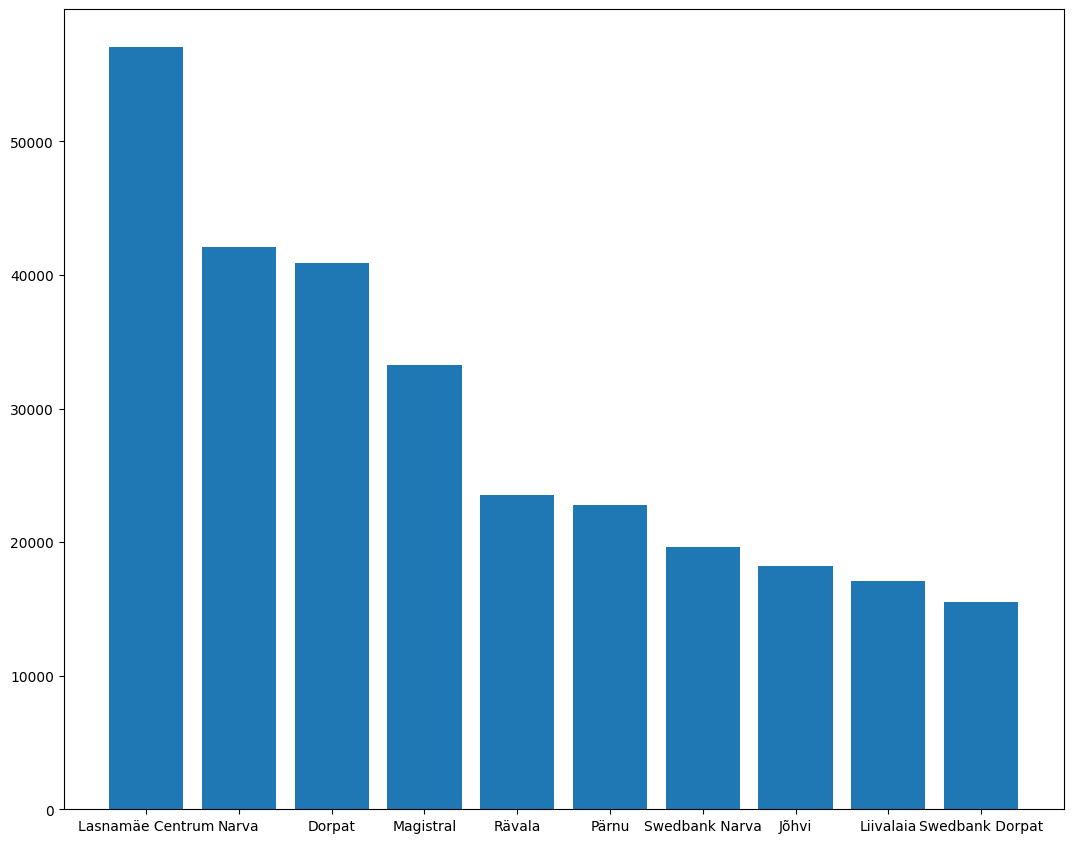

In [4]:
fig = plt.figure(figsize=(10, 8),dpi = 100)
ax = fig.add_axes([0,0,1,1])
ax.bar(branchs[:top_branch],nr_customers_per_branch[:top_branch])
plt.show()

In [5]:
# labels = data.Branch.value_counts().index.tolist()
# sizes = data.Branch.value_counts().values.tolist()
# # explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

# fig1, ax1 = plt.subplots(figsize=(20, 18),dpi = 400)
# ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
#         shadow=True, startangle=90)
# ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# plt.show()

### Group the number of customers per day for each branch

In [6]:
def removeIncorectDate(dataframe):
    tempo=[]
    for dt in dataframe['Service Time']:
        if len(dt.split(" "))==2:
            tempo.append(dt)
    return pd.DataFrame(data=tempo).rename(columns={0:'Service Time'})

In [7]:
def dataframe(dataframe,name_branch,monitoring=False):
    dataframe=data.loc[dataframe.Branch==name_branch,:].sort_values(by=['Service Time'])
    dataframe=removeIncorectDate(dataframe)['Service Time'].values
    nr_customer=0
    global_tempo=[]
    nr_customers_per_days=[]
    tempo=[]
    #Count number of clients per hours
    for idx,dt in enumerate(dataframe):
        if idx==0:
            if monitoring: print(dt)
            init_date=datetime.strptime(dt, '%Y-%m-%d %H:%M:%S')
            nr_customer+=1
        else:
            current_date=datetime.strptime(dt, '%Y-%m-%d %H:%M:%S')
            diff = relativedelta(current_date,init_date)
            if diff.hours<1:
                if monitoring: print(dt)
                nr_customer+=1
            else:
                init_date=datetime.strptime(dt, '%Y-%m-%d %H:%M:%S')
                tempo.append(nr_customer)
                if monitoring: print(nr_customer)
                nr_customer=0
                if diff.days>0:
                    global_tempo.append(tempo)
                    nr_customers_per_days.append(len(tempo))
                    tempo=[]
                    if monitoring: print(current_date)
                if monitoring: print("*******************")
                if monitoring: print(init_date)
    return global_tempo,np.mean(np.array(nr_customers_per_days)),np.std(np.array(nr_customers_per_days))

In [8]:
def windowCreator(lst_nr_customers,window,target=1):
    tempo=[]
    for lst in lst_nr_customers:
        for indx in range(len(lst)):
            x=lst[indx:indx+window]
            if len(x)==window:
                tempo.append(lst[indx:indx+window])
    return tempo

#### Prediction per branch

In [6]:
#Configuration
window=8
target=1
index_branch=0
name_branch=data.Branch.value_counts().index.tolist()[index_branch]
print(data.Branch.value_counts().index.tolist()[index_branch])

Lasnamäe Centrum


In [13]:
customers_distribution,average_customers_per_day,std_customers_per_day=dataframe(data,name_branch)

In [14]:
tempo=windowCreator(customers_distribution,window,1)
X=np.array(tempo)[:,:(window-1)]
y=np.array(tempo)[:,(window-1)]
del tempo
X.shape,y.shape

((1622, 7), (1622,))

<p>Training </p>

In [15]:
model = Sequential()
model.add(LSTM(100,activation='linear', return_sequences=True, input_shape=((window-1), target)))
model.add(LSTM(50,activation='linear'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

model.fit(X, y, epochs=150, verbose=0)

<p>Prediction </p>

True-> [38, 34, 39, 40, 42, 41, 37, 39, 35, 40, 53, 50, 35, 56, 40, 48, 31, 25, 36, 32, 36, 45, 45, 44]
Predict-> [38, 34, 39, 40, 42, 41, 37, 41, 39, 38, 45, 34, 28]


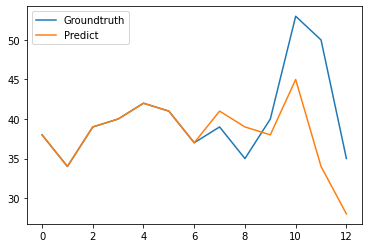

True-> [43, 58, 47, 51, 52, 50, 39, 37, 44, 35, 32, 44, 37, 53, 38, 43, 40, 34, 40, 36, 50, 38, 43, 36, 39, 46, 42, 33, 34, 49, 39, 41, 45, 46, 59, 28, 34, 34, 32, 40, 27, 50, 42, 34, 39, 37, 33, 28, 58, 41, 35]
Predict-> [43, 58, 47, 51, 52, 50, 39, 34, 41, 33, 34, 32, 41]


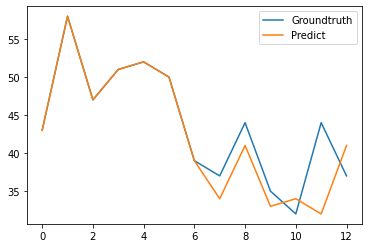

True-> [35, 28, 48, 36, 53, 44, 47, 52, 40, 30, 33, 49, 39, 45, 34, 43, 41, 30, 42, 42, 36, 44, 37, 31, 45, 40, 14, 40, 46, 29, 42, 39, 43, 28, 43, 30, 37, 38, 40, 35, 40, 36, 47, 40, 21, 34, 33, 35, 33, 81, 32]
Predict-> [35, 28, 48, 36, 53, 44, 47, 52, 38, 32, 33, 43, 33]


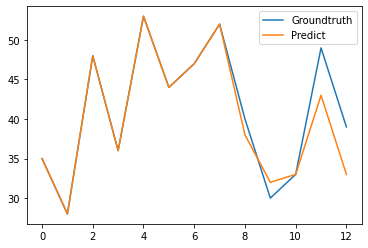

True-> [49, 39, 45, 40, 35, 58, 27, 39, 22, 43, 27, 42, 35, 48, 43, 48, 39, 18, 37, 35, 36, 43, 29, 35, 32, 30, 16, 38, 36, 29, 35, 44, 40, 42, 33, 9, 44, 34, 38, 45, 37, 37, 47, 36, 15, 40, 34, 32, 36, 40, 21]
Predict-> [49, 39, 45, 40, 35, 58, 27, 41, 19, 43, 29, 46, 32]


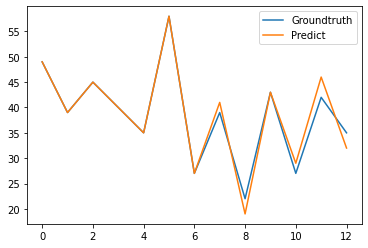

True-> [48, 36, 40, 50, 31, 43, 33, 40, 24, 45, 41, 45, 40, 46, 41, 38, 37, 26, 39, 41, 37, 34, 56, 41, 37, 33, 27, 36, 43, 28, 37, 35, 31, 33, 39, 24, 43, 33, 27, 50, 45, 41, 42, 37, 17, 44, 39, 27, 36, 33, 48, 6]
Predict-> [48, 36, 40, 50, 31, 43, 33, 38, 22, 45, 40, 52, 42]


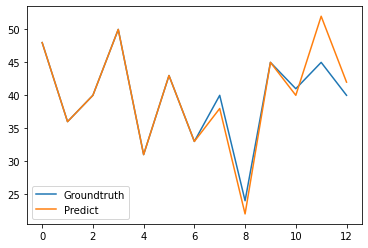

True-> [54, 37, 32, 55, 55, 53, 46, 40, 19, 36, 31, 32, 46, 43, 27, 38, 42, 28, 67, 42, 51, 44, 58, 50, 33, 51, 20, 40, 38, 47, 41, 52, 41, 37, 37, 23, 43, 45, 46, 47, 44, 43, 40, 48, 19, 45, 44, 33, 33, 56, 43]
Predict-> [54, 37, 32, 55, 55, 53, 46, 44, 20, 37, 29, 28, 39]


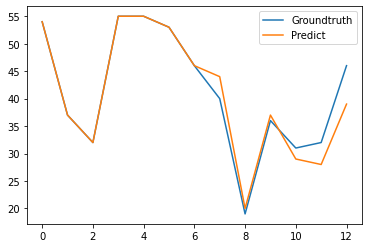

True-> [47, 35, 42, 55, 48, 37, 44, 47, 48, 38, 44, 54, 61, 38, 42, 51, 43, 49, 54, 19, 45, 41, 44, 40, 38, 41, 18, 46, 60, 48, 49, 41, 43, 28, 45, 25, 55, 44, 40, 41, 43, 47, 45, 47, 27, 52, 45, 52, 48, 57, 39]
Predict-> [47, 35, 42, 55, 48, 37, 44, 50, 45, 35, 50, 43, 35]


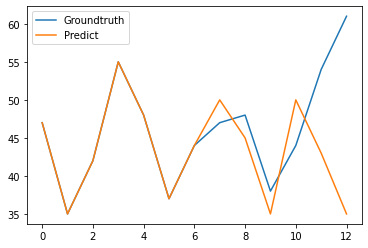

True-> [60, 50, 51, 51, 42, 58, 41, 45, 39, 44, 36, 49, 41, 37, 44, 46, 45, 46, 1, 60, 39, 49, 45, 49, 39, 30, 41, 26, 40, 41, 44, 33, 43, 34, 42, 54, 20, 38, 37, 38, 47, 37, 35, 39, 32, 15, 42, 29, 34, 60, 41, 34]
Predict-> [60, 50, 51, 51, 42, 58, 41, 41, 43, 42, 29, 38, 43]


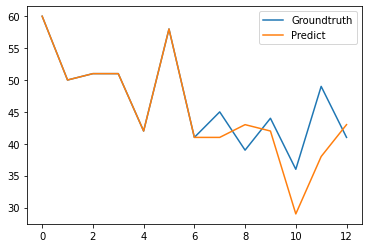

True-> [35, 48, 33, 56, 44, 38, 49, 32, 39, 35, 33, 46, 35, 27, 45, 30, 29, 14, 44, 42, 57, 43, 32, 40, 43, 29, 18, 43, 37, 38, 38, 40, 42, 45, 43, 39, 49, 33, 32, 33, 45, 40]
Predict-> [35, 48, 33, 56, 44, 38, 49, 36, 35, 33, 36, 38, 41]


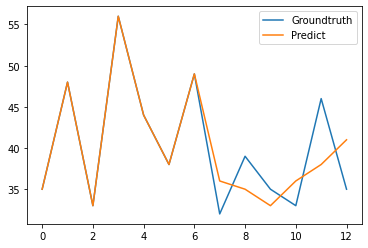

True-> [93, 95, 40, 40, 41, 33, 40, 39, 31, 50, 40, 52, 41, 56, 43, 43, 35, 19, 51, 33, 38, 37, 33, 40, 30, 33, 21, 49, 47, 55, 49, 55, 39, 34, 49, 19, 45, 36, 38, 39, 40, 32, 41, 32, 23, 50, 47, 33, 45, 38, 39]
Predict-> [93, 95, 40, 40, 41, 33, 40, 39, 32, 43, 37, 34, 39]


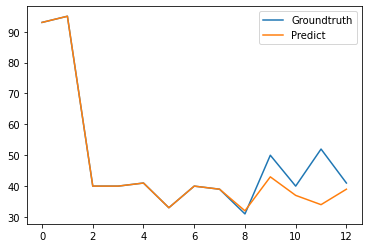

True-> [45, 43, 46, 58, 51, 35, 33, 45, 27, 41, 43, 47, 52, 34, 53, 44, 39, 38, 55, 38, 43, 40, 48, 42, 31, 47, 33, 50, 39, 46, 41, 46, 47, 48, 48, 28, 55, 39, 46, 49, 43, 39, 36, 42, 15, 53, 44, 41, 45, 41, 20]
Predict-> [45, 43, 46, 58, 51, 35, 33, 45, 18, 52, 41, 44, 43]


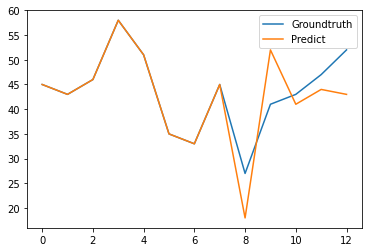

True-> [58, 45, 43, 45, 35, 54, 37, 46, 12, 58, 49, 38, 37, 34, 33, 35, 23, 7, 39, 33, 36, 30, 19, 59, 43, 42, 33, 25, 44, 35, 34, 56, 37]
Predict-> [58, 45, 43, 45, 35, 54, 37, 47, 14, 54, 47, 36, 36]


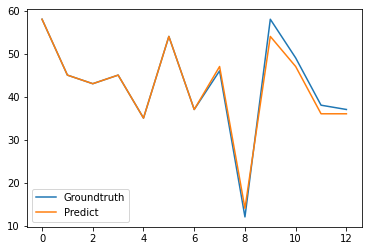

True-> [48, 47, 31, 41, 27, 35, 31, 39, 35, 26, 56, 46, 48, 57, 43, 43, 37, 33, 34, 37, 45, 46, 32, 24, 13]
Predict-> [48, 47, 31, 41, 27, 35, 31, 42, 36, 24, 47, 44, 45]


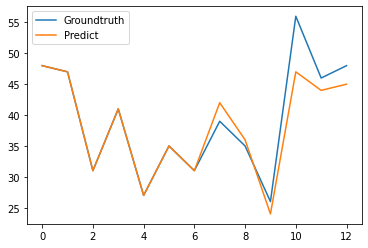

True-> [43, 38, 31, 31, 28, 43, 41, 24, 26, 22, 21, 13, 10, 12, 10, 22, 23, 14, 21, 42, 18, 15, 15, 17]
Predict-> [43, 38, 31, 31, 28, 43, 41, 23, 27, 23, 18, 11, 7]


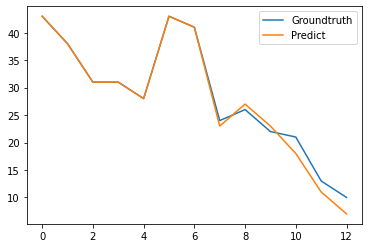

True-> [33, 24, 14, 23, 11, 27, 26, 28, 23, 11, 33, 29, 24, 20, 13, 37, 15, 16, 10, 10]
Predict-> [33, 24, 14, 23, 11, 27, 26, 30, 24, 9, 32, 30, 23]


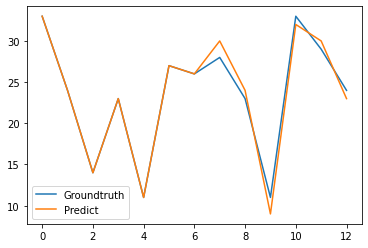

True-> [29, 23, 24, 15, 16, 24, 12, 10, 19, 7, 16, 20, 16, 17, 11, 25, 17, 17, 16, 6, 31, 20, 10, 13, 6]
Predict-> [29, 23, 24, 15, 16, 24, 12, 9, 18, 6, 17, 19, 17]


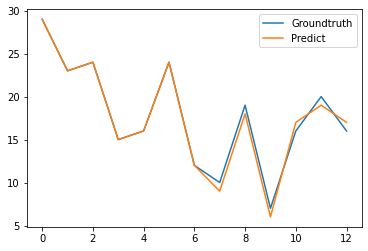

True-> [29, 13, 16, 17, 13, 21, 19, 13, 8, 9, 18, 23, 16, 11, 6, 12, 11, 19, 14, 7, 25, 12, 15, 12, 10]
Predict-> [29, 13, 16, 17, 13, 21, 19, 13, 10, 10, 20, 20, 15]


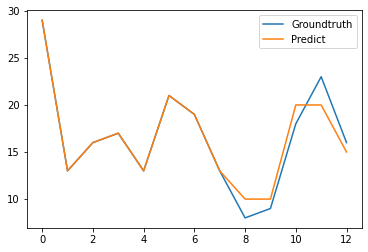

True-> [23, 7, 19, 10, 15, 9, 3, 19, 14, 18, 12, 9, 11, 1, 21, 14, 17, 16, 15, 12, 3, 20, 19, 11, 13, 11, 11, 2]
Predict-> [23, 7, 19, 10, 15, 9, 3, 20, 15, 18, 13, 10, 11]


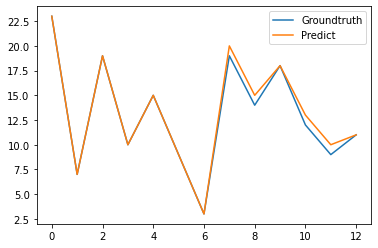

True-> [26, 21, 21, 17, 23, 22, 15, 10, 28, 20, 28, 17, 16, 17, 21, 10, 30, 21, 19, 15, 14, 14, 16, 11, 28, 21, 14, 28, 17, 16, 24, 1, 36, 21, 22, 23, 22, 18, 19, 9, 21, 19, 24, 14]
Predict-> [26, 21, 21, 17, 23, 22, 15, 7, 24, 18, 18, 22, 19]


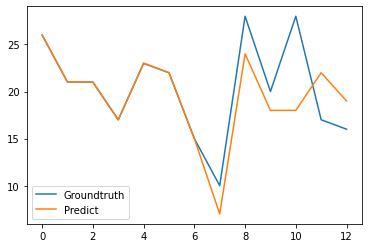

True-> [37, 23, 18, 27, 24, 22, 21, 5, 27, 24, 13, 19, 25, 19, 18, 8, 31, 24, 17, 20, 22, 21, 20, 9, 27, 15, 20, 19, 25, 18, 21, 8, 30, 22, 17, 21, 24, 20, 20, 9, 12, 21, 17, 6]
Predict-> [37, 23, 18, 27, 24, 22, 21, 6, 24, 18, 17, 21, 18]


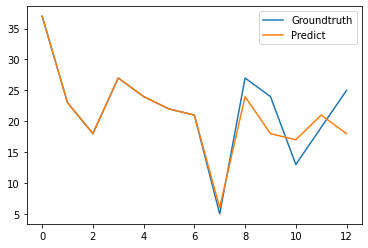

True-> [27, 19, 20, 23, 18, 21, 27, 6, 32, 18, 22, 19, 20, 20, 20, 5, 27, 20, 23, 27, 17, 17, 22, 7, 23, 16, 18, 19, 24, 16, 19, 9, 29, 21, 16, 19, 15, 18, 22, 11, 17, 20, 13, 18]
Predict-> [27, 19, 20, 23, 18, 21, 27, 6, 33, 19, 21, 21, 22]


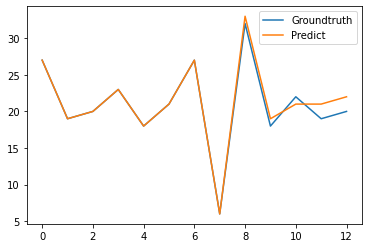

True-> [30, 24, 21, 22, 27, 23, 22, 13, 34, 18, 24, 22, 25, 24, 25, 11, 23, 16, 24, 10]
Predict-> [30, 24, 21, 22, 27, 23, 22, 12, 27, 20, 21, 24, 24]


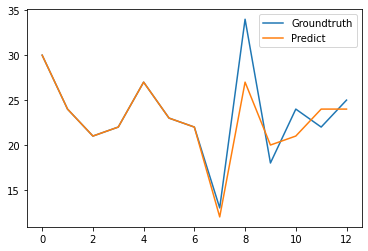

True-> [34, 23, 27, 15, 29, 21, 24, 9, 28, 17, 23, 26, 23, 26, 22, 13, 27, 27, 24, 24, 20, 27, 22, 22, 0, 31, 30, 26, 22, 26, 22, 21, 11, 34, 20, 18, 23, 18, 21, 18, 7, 26, 16, 19, 6]
Predict-> [34, 23, 27, 15, 29, 21, 24, 8, 28, 16, 22, 24, 22]


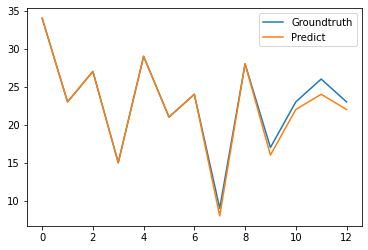

True-> [30, 31, 22, 23, 27, 26, 21, 12, 32, 26, 20, 18, 22, 23, 26, 11, 27, 20, 24, 23, 20, 28, 27, 12, 29, 27, 21, 20, 26, 20, 17, 11, 29, 18, 26, 23, 26, 24, 22, 10, 20, 18, 16, 14]
Predict-> [30, 31, 22, 23, 27, 26, 21, 12, 31, 24, 19, 18, 22]


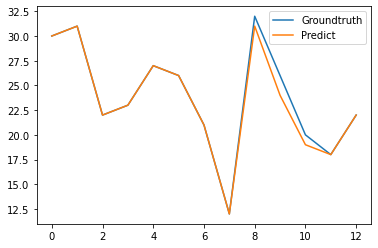

True-> [32, 26, 35, 18, 20, 25, 21, 8, 27, 30, 22, 21, 24, 19, 29, 6, 33, 21, 26, 18, 18, 19, 26, 9, 35, 20, 26, 21, 20, 18, 20, 2, 31, 23, 15, 19, 19, 15, 23, 4, 19, 15, 14, 8]
Predict-> [32, 26, 35, 18, 20, 25, 21, 6, 27, 27, 22, 21, 20]


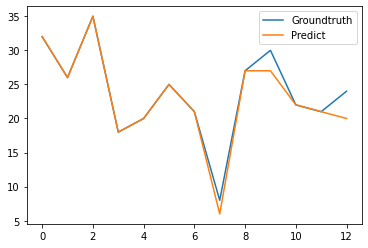

True-> [34, 22, 25, 31, 26, 30, 25, 3, 28, 23, 26, 17, 28, 20, 20, 14, 30, 19, 30, 25, 20, 22, 24, 9, 27, 22, 23, 18, 21, 27, 21, 10, 30, 20, 23, 21, 30, 25, 26, 11, 19, 16, 20, 9]
Predict-> [34, 22, 25, 31, 26, 30, 25, 3, 27, 23, 24, 16, 28]


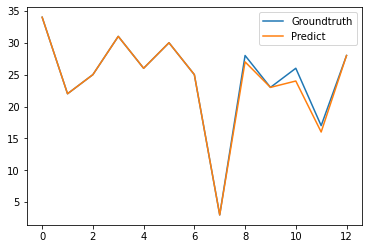

True-> [34, 22, 22, 23, 27, 20, 24, 15, 33, 21, 25, 17, 26, 24, 19, 11, 25, 20, 21, 22, 27, 24, 27, 3, 32, 18, 22, 22, 24, 19, 21, 13, 26, 21, 29, 25, 20, 33, 22, 5, 26, 27, 23, 8]
Predict-> [34, 22, 22, 23, 27, 20, 24, 12, 31, 21, 23, 22, 22]


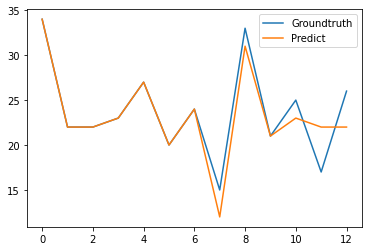

True-> [30, 26, 25, 24, 25, 25, 25, 8, 24, 22, 21, 24, 20, 22, 21, 12, 35, 26, 22, 23, 27, 20, 24, 12, 25, 24, 21, 22, 25, 23, 28, 12, 30, 18, 26, 18, 24, 24, 21, 13, 28, 19, 22, 12]
Predict-> [30, 26, 25, 24, 25, 25, 25, 7, 23, 21, 20, 25, 17]


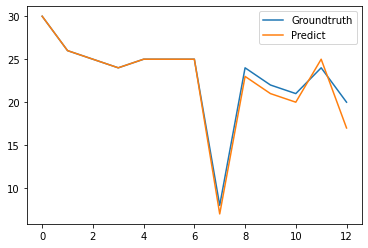

True-> [32, 29, 20, 21, 23, 25, 29, 10, 28, 30, 21, 29, 9, 33, 22, 27, 23, 27, 22, 18, 30, 27, 7, 32, 22, 23, 28, 23, 27, 26, 17, 31, 22, 25, 24, 25, 21, 33, 6, 31, 28, 24, 13]
Predict-> [32, 29, 20, 21, 23, 25, 29, 11, 28, 27, 20, 26, 13]


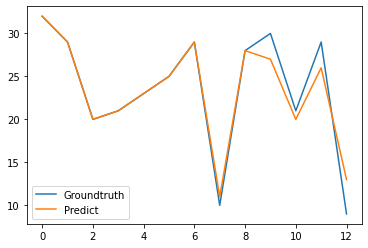

True-> [35, 18, 26, 19, 26, 27, 28, 12, 33, 19, 26, 25, 22, 20, 25, 10, 35, 23, 27, 23, 23, 24, 21, 14]
Predict-> [35, 18, 26, 19, 26, 27, 28, 12, 30, 19, 25, 25, 26]


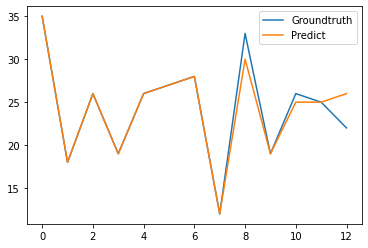

True-> [29, 20, 17, 21, 24, 20, 19, 5, 28, 20, 22, 15]
Predict-> [29, 20, 17, 21, 24, 20, 19, 4, 27, 21, 20, 21, 20]


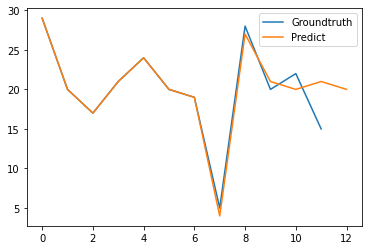

True-> [29, 20, 21, 18, 19, 21, 21, 1, 31, 18, 25, 26, 29, 31, 23, 14, 27, 22, 22, 19, 21, 23, 24, 17, 30, 22, 21, 17, 20, 21, 20, 8, 34, 19, 28, 22, 26, 27, 22, 12, 19, 21, 19, 7]
Predict-> [29, 20, 21, 18, 19, 21, 21, 0, 32, 18, 25, 27, 28]


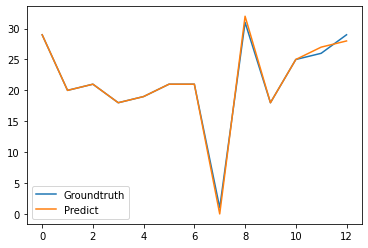

True-> [30, 18, 20, 18, 29, 24, 24, 17, 29, 20, 20, 23, 22, 23, 25, 6, 32, 21, 19, 20, 28, 21, 26, 12, 33, 19, 23, 21, 25, 20, 23, 11, 28, 23, 22, 21, 22, 27, 22, 13, 15, 16, 17, 7]
Predict-> [30, 18, 20, 18, 29, 24, 24, 14, 30, 19, 24, 19, 28]


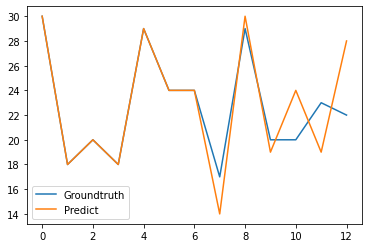

True-> [33, 32, 25, 28, 26, 22, 28, 12, 30, 24, 24, 26, 22, 28, 23, 11, 29, 20, 21, 26, 26, 25, 26, 3, 34, 21, 20, 19, 18, 17, 23, 9, 27, 23, 20, 26, 27, 23, 26, 4, 20, 13, 23, 11]
Predict-> [33, 32, 25, 28, 26, 22, 28, 12, 29, 23, 23, 26, 23]


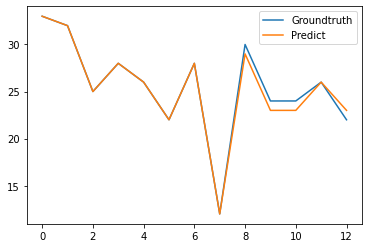

True-> [31, 24, 20, 23, 20, 17, 22, 8, 27, 24, 17, 24, 25, 18, 22, 11, 25, 25, 23, 26, 24, 24, 21, 17, 30, 21, 21, 22, 24, 20, 27, 13, 28, 23, 18, 23, 21, 24, 21, 12, 22, 11, 23, 6]
Predict-> [31, 24, 20, 23, 20, 17, 22, 5, 24, 26, 16, 21, 18]


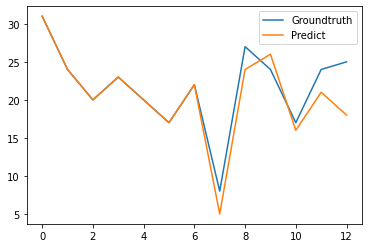

True-> [29, 17, 22, 22, 20, 21, 26, 13, 27, 28, 23, 23, 21, 20, 26, 8, 21, 26, 18, 23, 21, 19, 25, 13, 30, 17, 19, 4, 3, 1, 27, 25, 21, 22, 19, 21, 20, 7, 21, 10, 18, 11]
Predict-> [29, 17, 22, 22, 20, 21, 26, 11, 26, 22, 20, 23, 22]


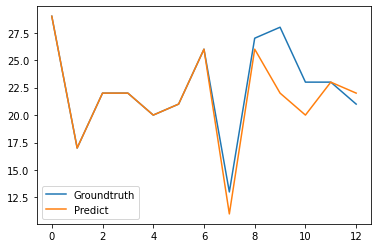

True-> [28, 21, 25, 22, 20, 21, 23, 12, 27, 19, 26, 23, 25, 21, 23, 10, 30, 19, 23, 20, 20, 17, 25, 6, 67, 35, 55, 37, 45, 43, 47, 21, 59, 47, 47, 45, 51, 49, 49, 7, 49, 29, 33, 21]
Predict-> [28, 21, 25, 22, 20, 21, 23, 11, 29, 20, 21, 18, 22]


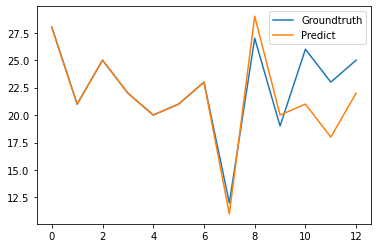

True-> [31, 22, 24, 23, 27, 21, 26, 10, 33, 27, 25, 31, 17, 27, 27, 5, 31, 22, 24, 21, 19, 18, 28, 7, 32, 14, 24, 4, 39, 23, 18, 8, 27, 20, 20, 25, 17, 24, 22, 9, 30, 21, 20, 16]
Predict-> [31, 22, 24, 23, 27, 21, 26, 10, 31, 23, 22, 25, 22]


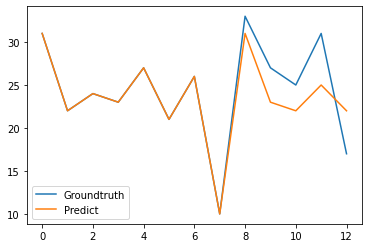

True-> [22, 25, 21, 29, 18, 23, 25, 9, 29, 22, 23, 22, 27, 30, 32, 12, 28, 25, 19, 28, 20, 28, 30, 13, 31, 32, 28, 17, 19, 25, 27, 5, 31, 26, 22, 22, 13, 25, 20, 2, 29, 24, 18, 13]
Predict-> [22, 25, 21, 29, 18, 23, 25, 11, 28, 20, 21, 19, 27]


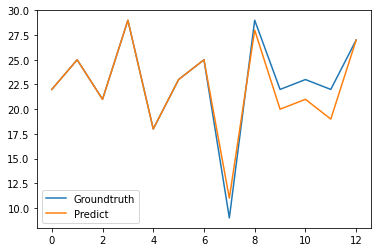

True-> [30, 22, 22, 25, 14, 23, 26, 7, 39, 21, 15, 19, 18, 24, 15, 0, 31, 22, 32, 27, 29, 22, 21, 1, 30, 26, 23, 25, 20, 31, 21, 4, 26, 19, 23, 19, 21, 26, 12, 0, 28, 21, 22, 6]
Predict-> [30, 22, 22, 25, 14, 23, 26, 7, 40, 21, 15, 20, 20]


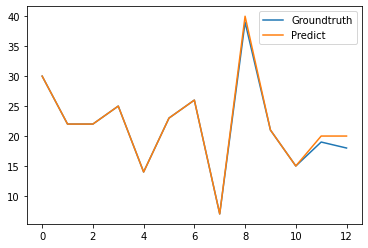

True-> [31, 22, 19, 22, 16, 25, 18, 1, 27, 22, 20, 18, 28, 22, 25, 4, 28, 20, 24, 21, 20, 22, 20, 0, 28, 22, 18, 19, 19, 15, 22, 5, 29, 25, 22, 19, 19, 22, 19, 0, 24, 14, 25, 6]
Predict-> [31, 22, 19, 22, 16, 25, 18, 3, 27, 21, 20, 22, 17]


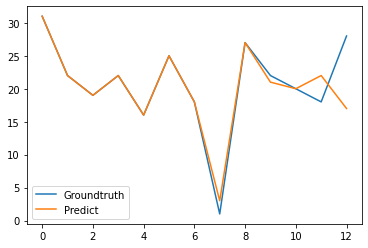

True-> [30, 25, 17, 25, 21, 19, 17, 35, 18, 19, 24, 20, 25, 14, 24, 20, 25, 21, 14, 21, 19, 1, 28, 21, 23, 27, 16, 24, 18, 1, 28, 21, 21, 23, 13, 16, 20, 10, 23, 14, 19, 13]
Predict-> [30, 25, 17, 25, 21, 19, 17, 35, 17, 20, 30, 22, 25]


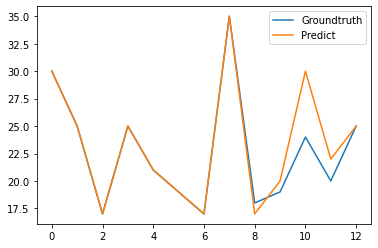

True-> [27, 18, 15, 18, 16, 23, 20, 3, 27, 26, 22, 22, 11, 22, 19, 7, 28, 21, 21, 24, 22, 19, 19, 0, 27, 19, 16, 20, 15, 17, 21, 0, 32, 18, 20, 20, 14, 17, 17, 2, 27, 19, 20, 6]
Predict-> [27, 18, 15, 18, 16, 23, 20, 3, 26, 27, 21, 20, 15]


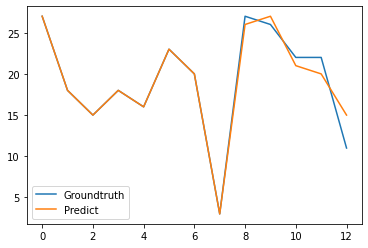

True-> [25, 23, 20, 19, 25, 24, 19, 31, 16, 23, 32, 23, 17, 14, 7, 27, 24, 21, 22, 23, 21, 19, 2, 30, 25, 25, 24, 17, 22, 17, 31, 15, 22, 26, 18, 22, 13, 29, 17, 19, 13]
Predict-> [25, 23, 20, 19, 25, 24, 19, 28, 15, 25, 22, 8, 27]


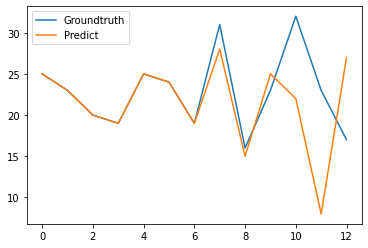

True-> [22, 18, 18, 17, 24, 18, 21, 2, 29, 15, 19, 12, 13, 18, 18, 0, 25, 21, 15, 25, 12, 21, 21, 1, 31, 17, 20, 19, 9, 20, 16, 2, 24, 22, 22, 16, 23, 21, 13, 2, 22, 16, 17, 12]
Predict-> [22, 18, 18, 17, 24, 18, 21, 1, 31, 18, 20, 17, 13]


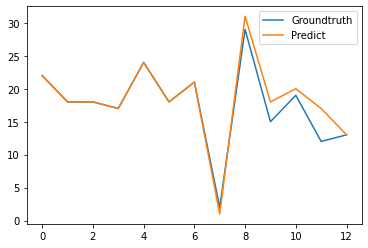

True-> [24, 18, 18, 19, 22, 18, 20, 5, 29, 22, 22, 27, 18, 19, 24, 3, 27, 28, 20, 19, 23, 21, 21, 2, 25, 23, 15, 20, 20, 16, 20, 12, 25, 21, 23, 20, 22, 18, 20, 5, 24, 23, 18, 16]
Predict-> [24, 18, 18, 19, 22, 18, 20, 5, 30, 20, 20, 23, 17]


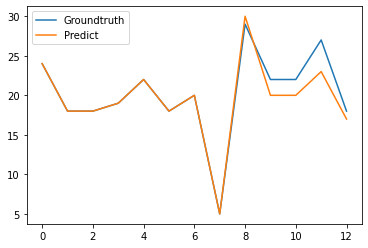

True-> [28, 18, 24, 27, 22, 19, 20, 12, 29, 19, 19, 16, 21, 20, 21, 9, 32, 20, 21, 21, 19, 20, 16, 4, 28, 22, 18, 23, 19, 22, 21, 1, 26, 19, 20, 18, 23, 17, 16, 9, 22, 13, 11, 6]
Predict-> [28, 18, 24, 27, 22, 19, 20, 8, 32, 26, 20, 23, 25]


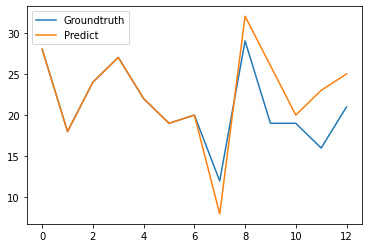

True-> [24, 17, 20, 25, 23, 21, 17, 3, 27, 17, 20, 17, 19, 19, 19, 5, 30, 17, 21, 16, 24, 23, 22, 2, 30, 20, 23, 24, 18, 22, 16, 6, 25, 17, 17, 24, 17, 15, 22, 15, 22, 14, 14, 10]
Predict-> [24, 17, 20, 25, 23, 21, 17, 2, 25, 16, 20, 15, 21]


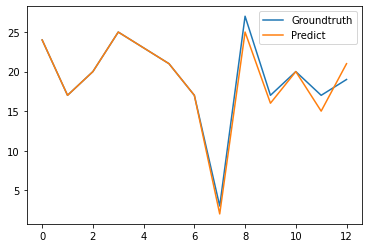

True-> [22, 19, 27, 21, 23, 16, 18, 13, 29, 16, 15, 12, 23, 18, 22, 4, 26, 17, 17, 19, 11]
Predict-> [22, 19, 27, 21, 23, 16, 18, 13, 29, 15, 18, 9, 19]


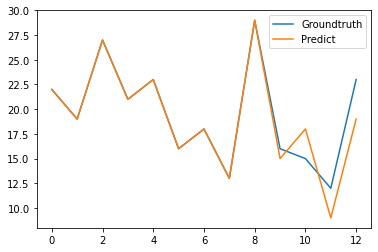

<Figure size 432x288 with 0 Axes>

In [16]:
for k in range(len(customers_distribution)):    
    position=k
    # nr_hours=len(customers_distribution[position])-(window-1)
    nr_hours=6
    seuence_init=customers_distribution[position][:(window-1)]
    sequence=[]

    for h in range(nr_hours):
        if h==0:
            x_input = np.array(seuence_init).reshape((1, (window-1), target))
    #         print(x_input)
            y_predict=int(model.predict(x_input, verbose=0)[0][0])
    #         print(y_predict)
            seuence_init=seuence_init+[y_predict]
    #         print(seuence_init)
        else:
            x_input = np.array(seuence_init[-(window-1):]).reshape((1, (window-1), target))
    #         print(x_input)
            y_predict=int(model.predict(x_input, verbose=0)[0][0])
    #         print(y_predict)
            seuence_init=seuence_init+[y_predict]
    #         print(seuence_init)
    #         print("**********")
    print(f'True-> {customers_distribution[position]}')
    print(f'Predict-> {seuence_init}')

    plt.plot(customers_distribution[position][:(window-1)+nr_hours], label = "Groundtruth")
    plt.plot(seuence_init, label = "Predict")
    plt.legend()
    plt.show()
    plt.clf()
    time.sleep(2)